Referências:

https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

https://github.com/s-miller/Spam-classification-comparing-Naive-Bayes-vs-random-forest-and-playing-around-with-sklearn-pipeline/blob/master/Spam%20classification%20comparing%20Naive%20Bayes%20vs%20random%20forest%20(and%20playing%20around%20with%20sklearn%20pipelining).ipynb

In [246]:
import pandas as pd
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

'''Modelos'''
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

In [247]:
def process_text(txt:str):
    '''Função que recebe o tweet e remove stopwords'''
    return [word for word in txt.split() if word not in stopwords.words('portuguese')]

In [248]:
tt = pd.read_csv('DebateGovRS_Anotado.xlsx - DebateGovRS_Anotado.csv').fillna(2)
tt.head()

,author_id,created_at,id,lang,retweet_count,text,sinal
0,"1,46E+18",2022-08-08T01:08:23Z,"1,56E+18",pt,45,RT @EdegarPretto O meu candidato vice-governad...,1.0
1,"1,51E+18",2022-08-08T01:08:23Z,"1,56E+18",pt,0,Periga o Argenta chamar o Simon pra responder ...,2.0
2,"1,06E+18",2022-08-08T01:08:21Z,"1,56E+18",pt,14,RT @WinstonLing Segue o link para assistirem o...,1.0
3,"7,15E+17",2022-08-08T01:08:20Z,"1,56E+18",pt,88,RT @EdegarPretto Eu quero dizer aos gaúchos e ...,2.0
4,1455004730,2022-08-08T01:08:20Z,"1,56E+18",pt,0,@wmfigueiredo @evertonvf @bandrs @EduardoLeite...,0.0


In [249]:
'''Seleciona somente os tweets classificados'''
tt = tt.loc[tt['sinal'].notna()]
tt.head()

,author_id,created_at,id,lang,retweet_count,text,sinal
0,"1,46E+18",2022-08-08T01:08:23Z,"1,56E+18",pt,45,RT @EdegarPretto O meu candidato vice-governad...,1.0
1,"1,51E+18",2022-08-08T01:08:23Z,"1,56E+18",pt,0,Periga o Argenta chamar o Simon pra responder ...,2.0
2,"1,06E+18",2022-08-08T01:08:21Z,"1,56E+18",pt,14,RT @WinstonLing Segue o link para assistirem o...,1.0
3,"7,15E+17",2022-08-08T01:08:20Z,"1,56E+18",pt,88,RT @EdegarPretto Eu quero dizer aos gaúchos e ...,2.0
4,1455004730,2022-08-08T01:08:20Z,"1,56E+18",pt,0,@wmfigueiredo @evertonvf @bandrs @EduardoLeite...,0.0


In [250]:
tt.loc[tt['sinal'] == 1,'sinal'] = 'Pos'
tt.loc[tt['sinal'] == 0,'sinal'] = 'Neg'
tt.loc[tt['sinal'] == 2,'sinal'] = 'Neu'
tt

,author_id,created_at,id,lang,retweet_count,text,sinal
0,"1,46E+18",2022-08-08T01:08:23Z,"1,56E+18",pt,45,RT @EdegarPretto O meu candidato vice-governad...,Pos
1,"1,51E+18",2022-08-08T01:08:23Z,"1,56E+18",pt,0,Periga o Argenta chamar o Simon pra responder ...,Neu
2,"1,06E+18",2022-08-08T01:08:21Z,"1,56E+18",pt,14,RT @WinstonLing Segue o link para assistirem o...,Pos
3,"7,15E+17",2022-08-08T01:08:20Z,"1,56E+18",pt,88,RT @EdegarPretto Eu quero dizer aos gaúchos e ...,Neu
4,1455004730,2022-08-08T01:08:20Z,"1,56E+18",pt,0,@wmfigueiredo @evertonvf @bandrs @EduardoLeite...,Neg
...,...,...,...,...,...,...,...
2995,"1,46E+18",2022-08-08T00:00:05Z,"1,56E+18",und,1,RT @josenery53 @SigaPepeVargas @DilmaResiste @...,Neu
2996,"1,37E+18",2022-08-08T00:00:05Z,"1,56E+18",pt,0,@onyxlorenzoni Realmente,Neu
2997,"1,19E+18",2022-08-08T00:00:04Z,"1,56E+18",pt,244,RT @bandrs Band mantém tradição e realiza o pr...,Neu
2998,54790300,2022-08-08T00:00:01Z,"1,56E+18",pt,20,RT @EdegarPretto O debate começou e você pode ...,Neu


In [251]:
'''Remove acentos e caracteres especiais / Coloca em minúscula'''
tt['text'] = tt['text'].str.lower().str.normalize('NFKD').str.encode('ascii',errors='ignore').str.decode('utf-8')
tt['text']

0       rt @edegarpretto o meu candidato vice-governad...
1       periga o argenta chamar o simon pra responder ...
2       rt @winstonling segue o link para assistirem o...
3       rt @edegarpretto eu quero dizer aos gauchos e ...
4       @wmfigueiredo @evertonvf @bandrs @eduardoleite...
                              ...                        
2995    rt @josenery53 @sigapepevargas @dilmaresiste @...
2996                            @onyxlorenzoni realmente 
2997    rt @bandrs band mantem tradicao e realiza o pr...
2998    rt @edegarpretto o debate comecou e voce pode ...
2999    @edegarpretto tem 51 anos e nasceu em miraguai...
Name: text, Length: 3000, dtype: object

In [252]:
'''Remove '\n', @, RT, #'''
tt['text'] = tt['text'].replace(to_replace=r'\\n',value=' ',regex=True)
tt['text'] = tt['text'].replace(to_replace=r'(?<!\w)@[\w+]{1,100}\b',value='',regex=True)
tt['text'] = tt['text'].replace(to_replace=r'^rt\s',value='',regex=True)
tt['text'] = tt['text'].replace(to_replace=r'(?<!\w)#[\w+]{1,100}\b',value='',regex=True)
tt

,author_id,created_at,id,lang,retweet_count,text,sinal
0,"1,46E+18",2022-08-08T01:08:23Z,"1,56E+18",pt,45,o meu candidato vice-governador e o fundador...,Pos
1,"1,51E+18",2022-08-08T01:08:23Z,"1,56E+18",pt,0,periga o argenta chamar o simon pra responder ...,Neu
2,"1,06E+18",2022-08-08T01:08:21Z,"1,56E+18",pt,14,segue o link para assistirem o debate de hoje...,Pos
3,"7,15E+17",2022-08-08T01:08:20Z,"1,56E+18",pt,88,eu quero dizer aos gauchos e gauchas que se e...,Neu
4,1455004730,2022-08-08T01:08:20Z,"1,56E+18",pt,0,aos que gostam governador atual quando for...,Neg
...,...,...,...,...,...,...,...
2995,"1,46E+18",2022-08-08T00:00:05Z,"1,56E+18",und,1,13,Neu
2996,"1,37E+18",2022-08-08T00:00:05Z,"1,56E+18",pt,0,realmente,Neu
2997,"1,19E+18",2022-08-08T00:00:04Z,"1,56E+18",pt,244,band mantem tradicao e realiza o primeiro deb...,Neu
2998,54790300,2022-08-08T00:00:01Z,"1,56E+18",pt,20,o debate comecou e voce pode acompanhar todos...,Neu


In [253]:
'''Remove espaços desnecessários'''
tt['text'] = tt['text'].str.rstrip().str.lstrip().str.replace('  ',' ')

In [254]:
'''Remove textos vazios'''
tt = tt[tt['text']!='']
tt

,author_id,created_at,id,lang,retweet_count,text,sinal
0,"1,46E+18",2022-08-08T01:08:23Z,"1,56E+18",pt,45,o meu candidato vice-governador e o fundador t...,Pos
1,"1,51E+18",2022-08-08T01:08:23Z,"1,56E+18",pt,0,periga o argenta chamar o simon pra responder ...,Neu
2,"1,06E+18",2022-08-08T01:08:21Z,"1,56E+18",pt,14,segue o link para assistirem o debate de hoje ...,Pos
3,"7,15E+17",2022-08-08T01:08:20Z,"1,56E+18",pt,88,eu quero dizer aos gauchos e gauchas que se eu...,Neu
4,1455004730,2022-08-08T01:08:20Z,"1,56E+18",pt,0,aos que gostam governador atual quando forem p...,Neg
...,...,...,...,...,...,...,...
2995,"1,46E+18",2022-08-08T00:00:05Z,"1,56E+18",und,1,13,Neu
2996,"1,37E+18",2022-08-08T00:00:05Z,"1,56E+18",pt,0,realmente,Neu
2997,"1,19E+18",2022-08-08T00:00:04Z,"1,56E+18",pt,244,band mantem tradicao e realiza o primeiro deba...,Neu
2998,54790300,2022-08-08T00:00:01Z,"1,56E+18",pt,20,o debate comecou e voce pode acompanhar todos ...,Neu


In [255]:
'''Remove registros repetidos'''
tt = tt.drop_duplicates(subset=['text'])
tt.reset_index(drop=True,inplace=True)
tt

,author_id,created_at,id,lang,retweet_count,text,sinal
0,"1,46E+18",2022-08-08T01:08:23Z,"1,56E+18",pt,45,o meu candidato vice-governador e o fundador t...,Pos
1,"1,51E+18",2022-08-08T01:08:23Z,"1,56E+18",pt,0,periga o argenta chamar o simon pra responder ...,Neu
2,"1,06E+18",2022-08-08T01:08:21Z,"1,56E+18",pt,14,segue o link para assistirem o debate de hoje ...,Pos
3,"7,15E+17",2022-08-08T01:08:20Z,"1,56E+18",pt,88,eu quero dizer aos gauchos e gauchas que se eu...,Neu
4,1455004730,2022-08-08T01:08:20Z,"1,56E+18",pt,0,aos que gostam governador atual quando forem p...,Neg
...,...,...,...,...,...,...,...
1618,17231726,2022-08-08T00:00:15Z,"1,56E+18",pt,1,economia solidaria esta incluida nos temas que...,Neu
1619,17231726,2022-08-08T00:00:11Z,"1,56E+18",pt,1,os jovens da roca nao querem ser agricultores ...,Neu
1620,120241898,2022-08-08T00:00:09Z,"1,56E+18",pt,0,uma otima oportunidade para o pessoal conhecer o,Neu
1621,"1,46E+18",2022-08-08T00:00:05Z,"1,56E+18",und,1,13,Neu


In [256]:
tt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1623 entries, 0 to 1622
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   author_id      1623 non-null   object
 1   created_at     1623 non-null   object
 2   id             1623 non-null   object
 3   lang           1623 non-null   object
 4   retweet_count  1623 non-null   int64 
 5   text           1623 non-null   object
 6   sinal          1623 non-null   object
dtypes: int64(1), object(6)
memory usage: 88.9+ KB


In [257]:
tt['sinal'].value_counts()

Neg    643
Neu    626
Pos    354
Name: sinal, dtype: int64

In [258]:
text_train, text_test, sinal_train, sinal_test = train_test_split(tt.text,tt.sinal,test_size=0.3)

In [259]:
sinal_train.value_counts()

Neg    467
Neu    426
Pos    243
Name: sinal, dtype: int64

In [260]:
sinal_test.value_counts()

Neu    200
Neg    176
Pos    111
Name: sinal, dtype: int64

# Suppor Vector Classifier
___

In [261]:
'''Suppor Vector Classifier Pipeline'''
svc_pipeline = Pipeline([
        ('bow', CountVectorizer(analyzer=process_text)),
        ('tfidf', TfidfTransformer()),
        ('classifier', SVC())
    ])

In [262]:
svc_pipeline.fit(text_train,sinal_train)
svc_pred = svc_pipeline.predict(text_test)

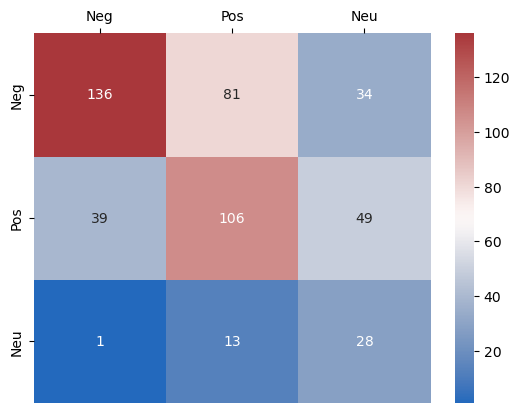

              precision    recall  f1-score   support

         Neg       0.77      0.54      0.64       251
         Neu       0.53      0.55      0.54       194
         Pos       0.25      0.67      0.37        42

    accuracy                           0.55       487
   macro avg       0.52      0.58      0.51       487
weighted avg       0.63      0.55      0.57       487



In [263]:
'''Confusion matrix'''
svc_cm = confusion_matrix(svc_pred,sinal_test)
sns.heatmap(svc_cm,annot=True,cmap='vlag',fmt='d',xticklabels=['Neg','Pos','Neu'],yticklabels=['Neg','Pos','Neu']).xaxis.tick_top()
plt.show()

'''Classification Report'''
svc_cr = classification_report(svc_pred,sinal_test)
print(svc_cr)

# Random Forest
___

In [264]:
'''Random Forest Pipeline'''
rfc_pipeline = Pipeline([
        ('bow', CountVectorizer(analyzer=process_text)),
        ('tfidf', TfidfTransformer()),
        ('classifier', RandomForestClassifier())
    ])

In [265]:
rfc_pipeline.fit(text_train,sinal_train)
rfc_pred = rfc_pipeline.predict(text_test)

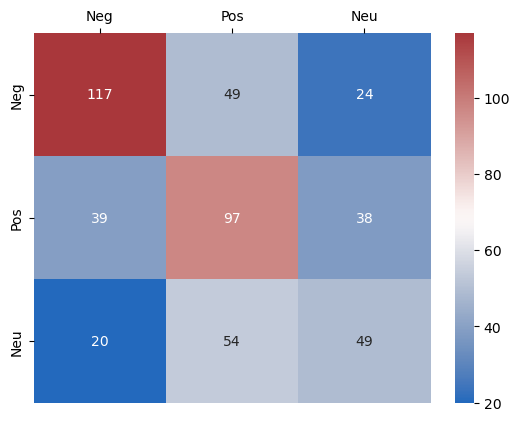

              precision    recall  f1-score   support

         Neg       0.66      0.62      0.64       190
         Neu       0.48      0.56      0.52       174
         Pos       0.44      0.40      0.42       123

    accuracy                           0.54       487
   macro avg       0.53      0.52      0.53       487
weighted avg       0.54      0.54      0.54       487



In [266]:
'''Confusion matrix'''
rfc_cm = confusion_matrix(rfc_pred,sinal_test)
sns.heatmap(rfc_cm,annot=True,cmap='vlag',fmt='d',xticklabels=['Neg','Pos','Neu'],yticklabels=['Neg','Pos','Neu']).xaxis.tick_top()
plt.show()

'''Classification Report'''
rfc_cr = classification_report(rfc_pred,sinal_test)
print(rfc_cr)

# KNN
___

In [267]:
'''KNN Pipeline'''
knn_pipeline = Pipeline([
        ('bow', CountVectorizer(analyzer=process_text)),
        ('tfidf', TfidfTransformer()),
        ('classifier', KNeighborsClassifier(n_neighbors=5))
    ])

In [268]:
knn_pipeline.fit(text_train,sinal_train)
knn_pred = knn_pipeline.predict(text_test)

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


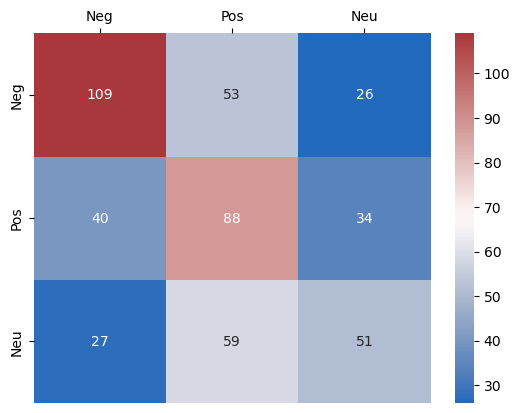

              precision    recall  f1-score   support

         Neg       0.62      0.58      0.60       188
         Neu       0.44      0.54      0.49       162
         Pos       0.46      0.37      0.41       137

    accuracy                           0.51       487
   macro avg       0.51      0.50      0.50       487
weighted avg       0.51      0.51      0.51       487



In [269]:
'''Confusion matrix'''
knn_cm = confusion_matrix(knn_pred,sinal_test)
sns.heatmap(knn_cm,annot=True,cmap='vlag',fmt='d',xticklabels=['Neg','Pos','Neu'],yticklabels=['Neg','Pos','Neu']).xaxis.tick_top()
plt.show()

'''Classification Report'''
knn_cr = classification_report(knn_pred,sinal_test)
print(knn_cr)

# Logistic Regression
___

In [270]:
'''Logistic Regression Pipeline'''
logReg_pipeline = Pipeline([
        ('bow', CountVectorizer(analyzer=process_text)),
        ('tfidf', TfidfTransformer()),
        ('classifier', LogisticRegression())
    ])

In [271]:
logReg_pipeline.fit(text_train,sinal_train)
logReg_pred = logReg_pipeline.predict(text_test)

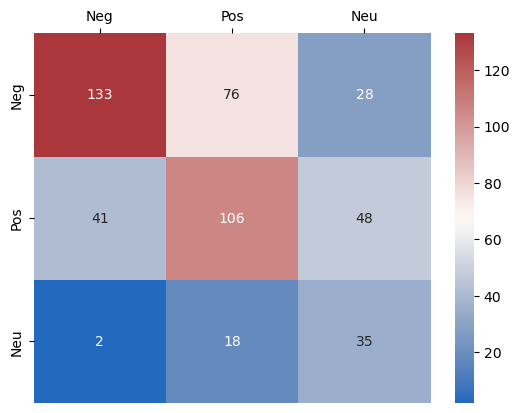

              precision    recall  f1-score   support

         Neg       0.76      0.56      0.64       237
         Neu       0.53      0.54      0.54       195
         Pos       0.32      0.64      0.42        55

    accuracy                           0.56       487
   macro avg       0.53      0.58      0.53       487
weighted avg       0.62      0.56      0.58       487



In [272]:
'''Confusion matrix'''
logReg_cm = confusion_matrix(logReg_pred,sinal_test)
sns.heatmap(logReg_cm,annot=True,cmap='vlag',fmt='d',xticklabels=['Neg','Pos','Neu'],yticklabels=['Neg','Pos','Neu']).xaxis.tick_top()
plt.show()

'''Classification Report'''
logReg_cr = classification_report(logReg_pred,sinal_test)
print(logReg_cr)

# MLP CLassifier 
___

In [273]:
'''MLP CLassifier Pipeline'''
mlp_pipeline = Pipeline([
        ('bow', CountVectorizer(analyzer=process_text)),
        ('tfidf', TfidfTransformer()),
        ('classifier', MLPClassifier(max_iter=300))
    ])

In [274]:
mlp_pipeline.fit(text_train,sinal_train)
mlp_pred = mlp_pipeline.predict(text_test)

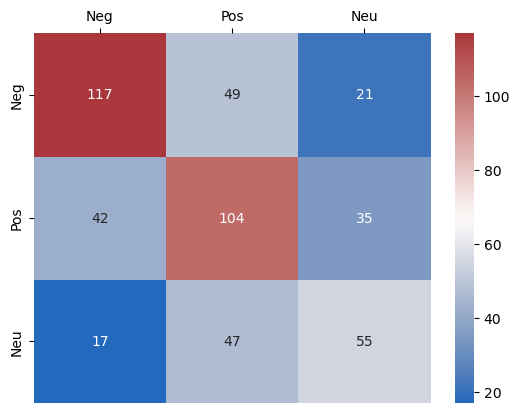

              precision    recall  f1-score   support

         Neg       0.66      0.63      0.64       187
         Neu       0.52      0.57      0.55       181
         Pos       0.50      0.46      0.48       119

    accuracy                           0.57       487
   macro avg       0.56      0.55      0.56       487
weighted avg       0.57      0.57      0.57       487



In [275]:
'''Confusion matrix'''
mlp_cm = confusion_matrix(mlp_pred,sinal_test)
sns.heatmap(mlp_cm,annot=True,cmap='vlag',fmt='d',xticklabels=['Neg','Pos','Neu'],yticklabels=['Neg','Pos','Neu']).xaxis.tick_top()
plt.show()

'''Classification Report'''
mlp_cr = classification_report(mlp_pred,sinal_test)
print(mlp_cr)

# Naive Bayes
___

In [276]:
'''MLP CLassifier Pipeline'''
mnb_pipeline = Pipeline([
        ('bow', CountVectorizer(analyzer=process_text)),
        ('tfidf', TfidfTransformer()),
        ('classifier', MultinomialNB())
    ])

In [277]:
mnb_pipeline.fit(text_train,sinal_train)
mnb_pred = mnb_pipeline.predict(text_test)

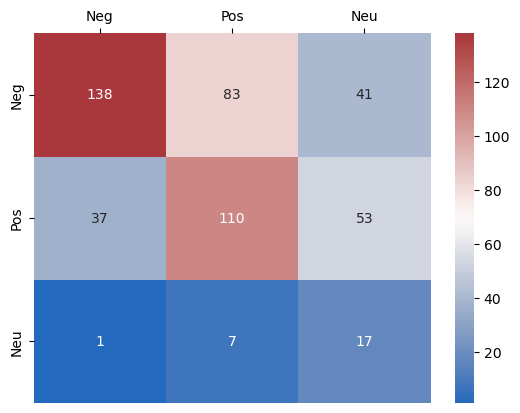

              precision    recall  f1-score   support

         Neg       0.78      0.53      0.63       262
         Neu       0.55      0.55      0.55       200
         Pos       0.15      0.68      0.25        25

    accuracy                           0.54       487
   macro avg       0.50      0.59      0.48       487
weighted avg       0.66      0.54      0.58       487



In [278]:
'''Confusion matrix'''
mnb_cm = confusion_matrix(mnb_pred,sinal_test)
sns.heatmap(mnb_cm,annot=True,cmap='vlag',fmt='d',xticklabels=['Neg','Pos','Neu'],yticklabels=['Neg','Pos','Neu']).xaxis.tick_top()
plt.show()

'''Classification Report'''
mnb_cr = classification_report(mnb_pred,sinal_test)
print(mnb_cr)